# Property rates and venues in western suburbs of Mumbai

### A. Introduction







### A.1. Description & Disscusion of the Background

Mumbai city is the capital of Maharashtra state in southwestern India. Mumbai is India’s most-populous city and is one of the largest and most densely populated urban areas in the world. 
Mumbai is the economic hub and commercial and financial centre of India. Because of the limited physical expanse of the city, the growth in Mumbai’s population has been accompanied by an astounding increase in population density. Additionally, the high overall growth rate is also largely attributable to the influx of people in search of employment. By the early 21st century the city had reached an average of some 77,000 persons per square mile (29,500 per square km).
This also provides an opportunity to investors to invest in Food and Beverage industry in the city.
We will analyze the western suburbs of the city and divide it in various clusters to guide the investors in choosing the venue to start their project.

### A.2. Data Description

The Western suburbs information has been obtained from the Wikipedia site.
Additionally, Foursquare API has been used to get the most common venues in the city.
To get an idea about the property rates, housing price averages have been obtained from housing retail web page. 
To consider the problem we can list the datas as belows


## B. Methodology

### B.1. Creating data table and data pre-processing

The wikipedia page has been scraped to get the information about the area and localities in Mumbai suburbs along with their latitude and longitude information.

In [319]:
#Import Libraries

#!pip install pandas
#!pip install requests
#!pip install bs4
#!pip install geopy

import pandas as pd 

from bs4 import BeautifulSoup
import requests # library to handle request

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json 
from pandas.io.json import json_normalize

!pip install folium
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


In [320]:
#Parse data from Wikipedia about Mumbai neighbourhoods
html= 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
html_data = requests.get(html).text

soup = BeautifulSoup(html_data,"html5lib")
table=soup.find('table')
#print(table.prettify())

In [321]:
#Convert Mumbai neighbourhood data into pandas dataframe
mumbai_data = pd.DataFrame(columns = ['Area','Location','Latitude','Longitude'])
for row in table.find_all('tr'):
    col = row.find_all('td')
    if (col != []):
        #print(col)
        area = col[0].text.strip().split(',')[0]
        location = (col[1].text).strip()
        if (len((location).split(','))>1):
            location=(location).split(',')[1]
        latitude = col[2].text.strip()
        longitude = col[3].text.strip()
        mumbai_data = mumbai_data.append({'Area':area,'Location':location, 'Latitude':latitude, 'Longitude':longitude},ignore_index=True)

        
print('The dataframe has {} location and {} area.'.format(
        len(mumbai_data['Location'].unique()),
        mumbai_data.shape[0]
    )
)
mumbai_data.groupby('Location').count()


The dataframe has 5 location and 93 area.


,Area,Latitude,Longitude
Location,,,
Eastern Suburbs,12,12,12
Harbour Suburbs,4,4,4
Mumbai,2,2,2
South Mumbai,39,39,39
Western Suburbs,36,36,36


#### We will focus on Western suburbs of Mumbai as part of this project.

In [322]:
mumbai_data = mumbai_data[mumbai_data["Location"]=="Western Suburbs"]
##cleaning the data to get the housing rates 
mumbai_data = mumbai_data.drop(mumbai_data.index[[31,32]]).reset_index(drop=True)
mumbai_data['Area'] = mumbai_data['Area'].replace(['Versova'],['Andheri'])
mumbai_data['Area'] = mumbai_data['Area'].replace(['Bangur Nagar'],['Goregaon'])
mumbai_data

,Area,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.1293,72.8434
1,Chakala,Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.82721
4,Lokhandwala,Western Suburbs,19.130815,72.82927
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.098889,72.867222
7,Seven Bungalows,Western Suburbs,19.129052,72.817018
8,Andheri,Western Suburbs,19.12,72.82
9,Mira Road,Western Suburbs,19.284167,72.871111


#### Webscrape the housing retail website to get the average housing rates for each area in western suburbs

In [323]:
html1= 'https://www.99acres.com/property-rates-and-price-trends-in-mumbai'
html_data1 = requests.get(html1).text

soup1 = BeautifulSoup(html_data1,"html5lib")
table1=soup1.find('table')
#print(table1.prettify())

In [324]:
df = pd.DataFrame(columns = ['Locality','Price range'])
for row in table1.find_all('tr'):
    col = row.find_all('td')
    
    if (col != []):
        locality = (((col[0].text).strip()).split('(')[0]).strip()
        if (col[1].text.strip() != '-'):
            price= (((col[1].text.strip()).replace("Rs.","")).replace("/sq. ft.","")).replace(",","")
            avg = (int(price.split('-')[0].strip()) + int(price.split('-')[1].strip()))/2
        else:
            avg=None   
        df= df.append({'Locality':locality, 'Price range':avg},ignore_index=True)

#cleaning the data for further analysis
                      
df['Locality'] = df['Locality'].replace(["Bandra",'Lokhandwala Andheri West','Jogeshwari','Khar Danda'],['Bandstand Promenade','Lokhandwala','Jogeshwari West','Khar'])
                      
df.dropna(inplace=True)


In [325]:
#Merge the western suburbs data ith their average housing price
mumbai_merged = mumbai_data
mumbai_merged = mumbai_merged.join(df.set_index('Locality'), on='Area')

mumbai_merged.dropna(inplace=True)
mumbai_merged = mumbai_merged.groupby(['Area']).first().reset_index()
mumbai_merged

,Area,Location,Latitude,Longitude,Price range
0,Aarey Milk Colony,Western Suburbs,19.148493,72.881756,8160.0
1,Amboli,Western Suburbs,19.1293,72.8434,19061.5
2,Andheri,Western Suburbs,19.12,72.82,16533.0
3,Bandstand Promenade,Western Suburbs,19.042718,72.819132,29686.5
4,Chakala,Western Suburbs,19.111388,72.860833,19018.5
5,Charkop,Western Suburbs,19.216182,72.830575,12686.5
6,Dahisar,Western Suburbs,19.250069,72.859347,11432.5
7,Dindoshi,Western Suburbs,19.176382,72.864891,13897.5
8,Gorai,Western Suburbs,19.250057,72.782021,15512.5
9,Goregaon,Western Suburbs,19.167362,72.832252,16044.0


### B.2. Visual Map & Clustering in Borough

Folium library is used to visualize geographic details of Mumbai western suburbs neighbourhood.
Geopy library is used to get the latitude and longitude values of mumbai.

In [326]:
address = 'Mumbai,India'

geolocator = Nominatim(user_agent="ind_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 19.0759899, 72.8773928.


In [327]:
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, area, location in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Area'], mumbai_merged['Location']):
    label = '{}, {}'.format(area, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

#### The Foursquare API is used to explore the boroughs and segment them.
#### First create the GET request URL. The limit is set to 100 venue and the radius 1000 meter for each borough

In [328]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 1000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

From the Foursquare lab, we know that all the information is in the items key. Before we proceed, let's categorize the venues in get_category_type function.

In [329]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe

In [330]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

16 venues were returned by Foursquare.


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,The Bar Stock Exchange,Bar,19.071166,72.876359
1,Delhi Zaika,Indian Restaurant,19.077054,72.878260
2,Pizza Hut,Pizza Place,19.075984,72.877656
3,24 Shisha Lounge,Lounge,19.072410,72.870194
4,Sahara Restaurant,Mughlai Restaurant,19.079532,72.880152


### B.3. Exploring Boroughs in Mumbai Western suburbs
Let's create a function to get all the boroughs in Mumbai

In [331]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can run the above function on each borough and create a new dataframe called mumbai_venues


In [332]:
mumbai_venues = getNearbyVenues(names=mumbai_merged['Area'],
                                   latitudes=mumbai_merged['Latitude'],
                                   longitudes=mumbai_merged['Longitude']
                                  )

Aarey Milk Colony
Amboli
Andheri
Bandstand Promenade
Chakala
Charkop
Dahisar
Dindoshi
Gorai
Goregaon
Irla
Jogeshwari West
Juhu
Kalina
Kherwadi
Lokhandwala
Mahavir Nagar
Marol
Mira Road
Pali Hill
Poisar
Sunder Nagar
Vile Parle
Virar


Check the size of the resulting dataframe

In [333]:
print(mumbai_venues.shape)
mumbai_venues.head()

(1019, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,19.148493,72.881756,BeFit,19.153570,72.885704,Gym / Fitness Center
1,Aarey Milk Colony,19.148493,72.881756,Aarey Garden Restaurant,19.155514,72.878236,Indian Restaurant
2,Aarey Milk Colony,19.148493,72.881756,Aarey Milk Colony,19.155678,72.884400,Farm
3,Aarey Milk Colony,19.148493,72.881756,Brown Sugar Cafe,19.155844,72.885963,Café
4,Aarey Milk Colony,19.148493,72.881756,Piccadilly 1 Royal Palms,19.154132,72.885084,Hotel


Let's check how many venues were returned for each borough and sort them in count

In [334]:
print('There are {} uniques categories.'.format(len(mumbai_venues['Venue Category'].unique())))
mumbai_venues.groupby('Neighborhood').count()

There are 142 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aarey Milk Colony,8,8,8,8,8,8
Amboli,32,32,32,32,32,32
Andheri,33,33,33,33,33,33
Bandstand Promenade,21,21,21,21,21,21
Chakala,40,40,40,40,40,40
Charkop,11,11,11,11,11,11
Dahisar,24,24,24,24,24,24
Dindoshi,47,47,47,47,47,47
Gorai,4,4,4,4,4,4


#### Lets analyze the top 25 categegory-wise count distribution of the venues

Horizontal bar chart has been used to analyze the same.

In [335]:
category = mumbai_venues.groupby('Venue Category').count()
category = category['Venue'].to_frame().reset_index(drop=False).sort_values(by="Venue", ascending=False)
category.rename({'Venue': 'count'}, axis=1, inplace=True)
category = category.head(25)


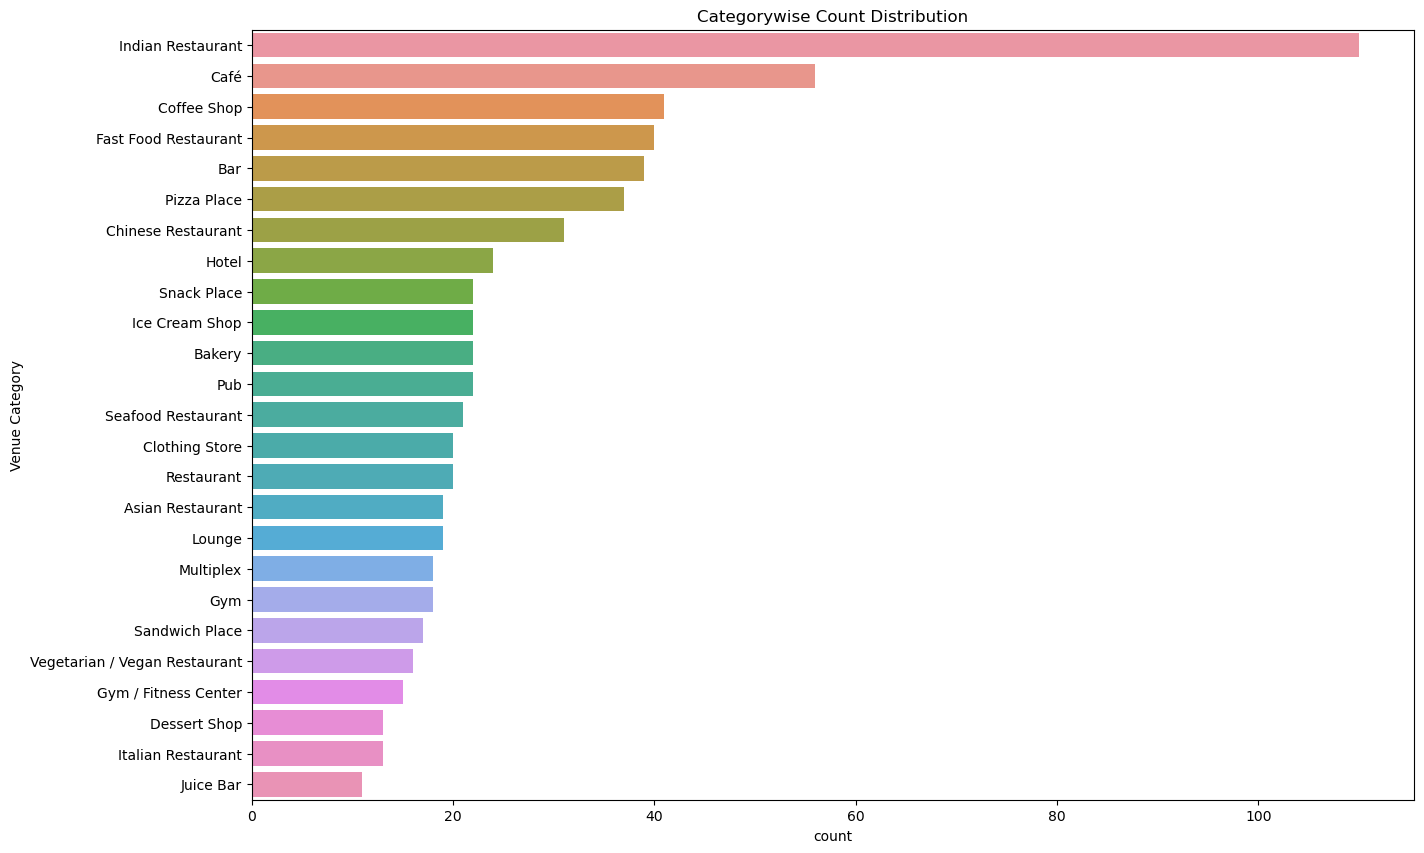

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = sns.barplot(x="count", y="Venue Category", data=category)
plt.title("Categorywise Count Distribution")
plt.show()

#### Let's check how many venues were returned for each neighborhood and sort them in count


In [337]:
summary = mumbai_venues.groupby('Neighborhood').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Count
0,Gorai,4,4,4,4,4,4,4
1,Virar,7,7,7,7,7,7,7
2,Aarey Milk Colony,8,8,8,8,8,8,8
3,Charkop,11,11,11,11,11,11,11
4,Marol,18,18,18,18,18,18,18


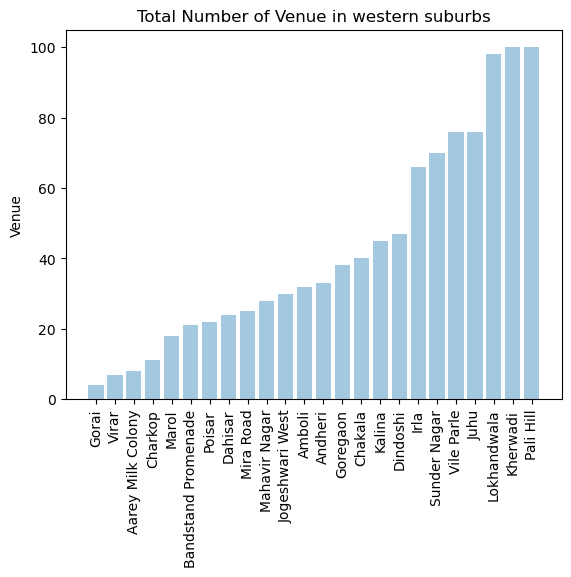

In [338]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Neighborhood
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in western suburbs')
plt.xticks(rotation=90)

plt.show()

Here is we can see that Pali Hill and Kherwadi have reached the 100 limit of venues. On the other hand; Gorai,Virar,Aarey colony,Charkop and Marol neighborhoods are below 20 venues in our given coordinates with Latitude and Longitude.

The result doesn't mean that inquiry run all the possible results in neighborhoods. Actually, it depends on given Latitude and Longitude informations and here is we just run single Latitude and Longitude pair for each borough. We can increase the possibilities with Neighborhood informations with more Latitude and Longitude informations.


### B.4. Analyzing each Neighborhood
We will anayze each neighborhood with venues informations

In [339]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Neighborhood'] = mumbai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

print(mumbai_onehot.shape)
mumbai_onehot.head()

(1019, 143)


,Neighborhood,Accessories Store,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,...,Steakhouse,Sushi Restaurant,Tea Room,Theater,Theme Park,Trail,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Yoga Studio
0,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [340]:

mumbai_grouped = mumbai_onehot.groupby('Neighborhood').mean().reset_index()
##Removing data for Aarey, Gorai and virar due to limited number of venues.
mumbai_grouped = mumbai_grouped.drop(mumbai_grouped.index[[0,8,23]]).reset_index(drop=True)
mumbai_merged = mumbai_merged.drop(mumbai_merged.index[[0,8,23]]).reset_index(drop=True)

mumbai_grouped

,Neighborhood,Accessories Store,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,...,Steakhouse,Sushi Restaurant,Tea Room,Theater,Theme Park,Trail,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Yoga Studio
0,Amboli,0.000000,0.000000,0.000000,0.062500,0.031250,0.000000,0.000000,0.125000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.031250,0.031250,0.000000,0.000000
1,Andheri,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.030303,0.000000,0.000000
2,Bandstand Promenade,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.047619,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chakala,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.050000,0.000000,0.000000
4,Charkop,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,Dahisar,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.083333,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.041667,0.000000,0.000000,0.000000
6,Dindoshi,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.021277,0.042553,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.021277,0.000000,0.063830,0.021277,0.000000
7,Goregaon,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.026316,0.000000,0.000000
8,Irla,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000,0.030303,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.015152,0.000000,0.000000
9,Jogeshwari West,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.033333,0.000000,0.000000


Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [341]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [342]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['Neighborhood'] = mumbai_grouped['Neighborhood']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Indian Restaurant,Bar,Pizza Place,Pub,Asian Restaurant,Chinese Restaurant,Bowling Alley,Metro Station,Burger Joint,Sandwich Place
1,Andheri,Indian Restaurant,Café,Multiplex,Coffee Shop,Pub,Chinese Restaurant,Movie Theater,North Indian Restaurant,Pharmacy,Pizza Place
2,Bandstand Promenade,Coffee Shop,Scenic Lookout,Food Truck,Italian Restaurant,Beach,Chinese Restaurant,Lounge,Boutique,Boat or Ferry,Cocktail Bar
3,Chakala,Hotel,Indian Restaurant,Seafood Restaurant,Café,Vegetarian / Vegan Restaurant,Restaurant,Chinese Restaurant,Fast Food Restaurant,Multiplex,Pizza Place
4,Charkop,Fast Food Restaurant,Gym,Café,Gym / Fitness Center,Pizza Place,Playground,Plaza,Smoke Shop,Snack Place,Chinese Restaurant


### B.5. Cluster of Neighborhood
K-Means algorithm is one of the most common cluster method of unsupervised learning. I will use K-Means algorithm for my study in this project.

First, I will run K-Means to cluster the boroughs into 3 clusters as the K-Means with elbow method ensured the degree 3 for optimum k of the K-Means.

In [343]:
print(mumbai_grouped_clustering.shape)
# set number of clusters
kclusters = 3

mumbai_grouped_clustering = mumbai_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

(21, 142)


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0],
      dtype=int32)

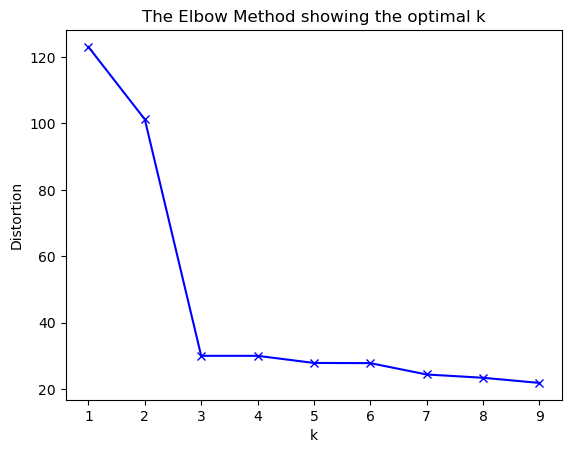

In [344]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(mumbai_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(mumbai_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / mumbai_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [345]:

# add clustering labels

#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mumbai_cluster = mumbai_merged
mumbai_cluster['Cluster Labels'] = kmeans.labels_

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
mumbai_cluster = mumbai_cluster.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Area')

mumbai_cluster.head() # check the last columns!



,Area,Location,Latitude,Longitude,Price range,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.1293,72.8434,19061.5,0,Indian Restaurant,Bar,Pizza Place,Pub,Asian Restaurant,Chinese Restaurant,Bowling Alley,Metro Station,Burger Joint,Sandwich Place
1,Andheri,Western Suburbs,19.12,72.82,16533.0,0,Indian Restaurant,Café,Multiplex,Coffee Shop,Pub,Chinese Restaurant,Movie Theater,North Indian Restaurant,Pharmacy,Pizza Place
2,Bandstand Promenade,Western Suburbs,19.042718,72.819132,29686.5,0,Coffee Shop,Scenic Lookout,Food Truck,Italian Restaurant,Beach,Chinese Restaurant,Lounge,Boutique,Boat or Ferry,Cocktail Bar
3,Chakala,Western Suburbs,19.111388,72.860833,19018.5,0,Hotel,Indian Restaurant,Seafood Restaurant,Café,Vegetarian / Vegan Restaurant,Restaurant,Chinese Restaurant,Fast Food Restaurant,Multiplex,Pizza Place
4,Charkop,Western Suburbs,19.216182,72.830575,12686.5,1,Fast Food Restaurant,Gym,Café,Gym / Fitness Center,Pizza Place,Playground,Plaza,Smoke Shop,Snack Place,Chinese Restaurant


#### Bar chart has been created to analyze the first most common venue in each cluster.


In [346]:
count_venue = mumbai_cluster
count_venue = count_venue.drop(['Area','Price range', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Bar,Café,Coffee Shop,Fast Food Restaurant,Gym,Hotel,Indian Restaurant,Juice Bar,Pizza Place
0,1,1,3,2,1,1,6,1,1
1,0,0,0,2,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0


Text(0, 0.5, 'Number of Venue')

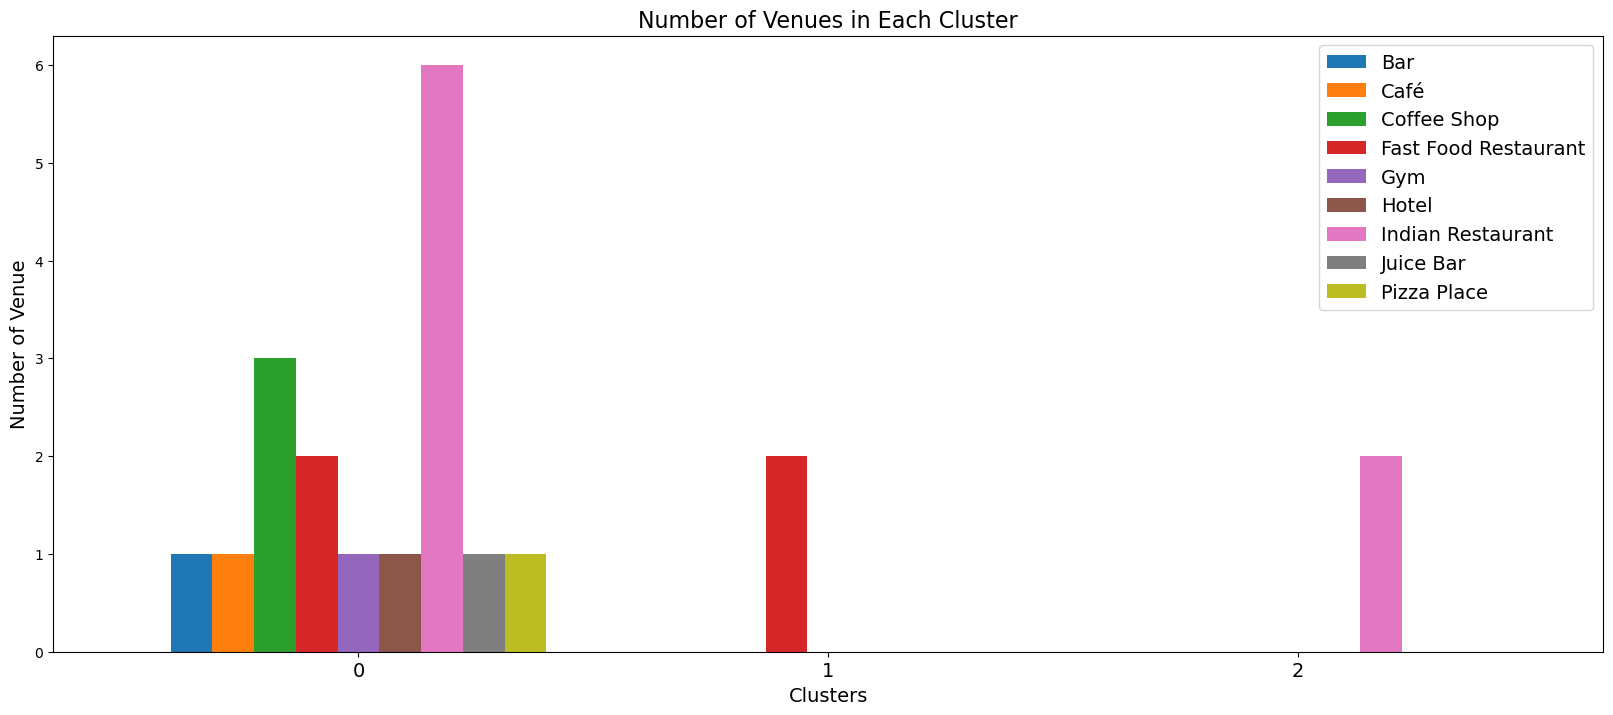

In [289]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Venue', fontsize=14)


When we examine above graph we can label see that Cluster 0 is a hotspot for Food and Beverage places and could be a good place for the investment.


#### The box plot has also been created to analyze the average price range in each cluster.

In [347]:
pr_range = mumbai_cluster
pr_range = pr_range[["Area","Price range",'Cluster Labels']]
pr = pr_range.pivot(index='Area', columns='Cluster Labels', values="Price range")
pr.head(50)


Cluster Labels,0,1,2
Area,,,
Amboli,19061.5,NaN,NaN
Andheri,16533.0,NaN,NaN
Bandstand Promenade,29686.5,NaN,NaN
Chakala,19018.5,NaN,NaN
Charkop,NaN,12686.5,NaN
Dahisar,11432.5,NaN,NaN
Dindoshi,13897.5,NaN,NaN
Goregaon,16044.0,NaN,NaN
Irla,24013.0,NaN,NaN


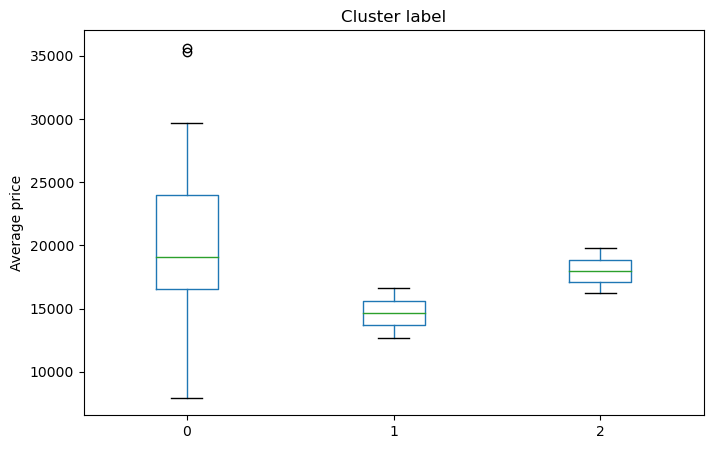

In [348]:
pr.plot(kind='box', figsize=(8, 5))

plt.title('Cluster label')
plt.ylabel('Average price')

plt.show()

The above plot gives an overview about the price range in various clusters and the investor can choose a place as per their budget.

## C. Results

### C.1. Main table with results

#### The tables below shows the various cluster neighborhoods with their average price ranges in sorted order.

In [349]:
mum_clus0 = mumbai_cluster.loc[mumbai_cluster['Cluster Labels'] == 0, mumbai_cluster.columns[[0] + list(range(4, mumbai_cluster.shape[1]))]]
mum_clus0 = mum_clus0.sort_values('Price range').reset_index(drop=True)
mum_clus0

,Area,Price range,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mira Road,7947.0,0,Pizza Place,Indian Restaurant,Café,Gym / Fitness Center,Multiplex,Pharmacy,Sandwich Place,Fast Food Restaurant,Convenience Store,Electronics Store
1,Dahisar,11432.5,0,Juice Bar,Chinese Restaurant,Café,Bar,Indian Restaurant,Ice Cream Shop,Diner,Pharmacy,Pizza Place,Restaurant
2,Dindoshi,13897.5,0,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Shopping Mall,Coffee Shop,Ice Cream Shop,Indian Restaurant,Bar,Donut Shop,Multiplex,Clothing Store
3,Goregaon,16044.0,0,Coffee Shop,Clothing Store,Indian Restaurant,Multiplex,Fast Food Restaurant,Pizza Place,Electronics Store,Pub,Restaurant,Business Service
4,Andheri,16533.0,0,Indian Restaurant,Café,Multiplex,Coffee Shop,Pub,Chinese Restaurant,Movie Theater,North Indian Restaurant,Pharmacy,Pizza Place
5,Sunder Nagar,17892.5,0,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Café,Chinese Restaurant,Multiplex,Pizza Place,Clothing Store,Restaurant,Gym
6,Mahavir Nagar,18551.0,0,Fast Food Restaurant,Indian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Snack Place,Chinese Restaurant,Electronics Store,Mexican Restaurant,Juice Bar
7,Chakala,19018.5,0,Hotel,Indian Restaurant,Seafood Restaurant,Café,Vegetarian / Vegan Restaurant,Restaurant,Chinese Restaurant,Fast Food Restaurant,Multiplex,Pizza Place
8,Amboli,19061.5,0,Indian Restaurant,Bar,Pizza Place,Pub,Asian Restaurant,Chinese Restaurant,Bowling Alley,Metro Station,Burger Joint,Sandwich Place
9,Kalina,21845.0,0,Gym,Clothing Store,Indian Restaurant,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Furniture / Home Store,Steakhouse,Electronics Store,Café


In [350]:
mumbai_cluster.loc[mumbai_cluster['Cluster Labels'] == 1, mumbai_cluster.columns[[0] + list(range(4, mumbai_cluster.shape[1]))]]

,Area,Price range,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Charkop,12686.5,1,Fast Food Restaurant,Gym,Café,Gym / Fitness Center,Pizza Place,Playground,Plaza,Smoke Shop,Snack Place,Chinese Restaurant
18,Poisar,16617.0,1,Fast Food Restaurant,Food Truck,Gym,Coffee Shop,Snack Place,Italian Restaurant,Food,Flea Market,Dessert Shop,Pizza Place


In [351]:
mumbai_cluster.loc[mumbai_cluster['Cluster Labels'] == 2, mumbai_cluster.columns[[0] + list(range(4, mumbai_cluster.shape[1]))]]

,Area,Price range,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Jogeshwari West,19762.5,2,Indian Restaurant,Camera Store,Fast Food Restaurant,Café,Restaurant,Bus Station,Burger Joint,Chinese Restaurant,Sandwich Place,Department Store
15,Marol,16256.5,2,Indian Restaurant,Hotel,Farmers Market,Snack Place,Lounge,Asian Restaurant,Ice Cream Shop,Diner,Coffee Shop,Fast Food Restaurant


### C.2. Map of Cluster Results


#### Lets visualize the various clusters on the map of Mumbai.


In [352]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_cluster['Latitude'], mumbai_cluster['Longitude'], mumbai_cluster['Area'], mumbai_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters




## D. Discussion


As I mentioned before, Mumbai is a big city with a high population density in a narrow area. The total number of measurements and population densities of the western suburbs in total can vary. As there is such a complexity, very different approaches can be tried in clustering and classification studies. Moreover, it is obvious that not every classification method can yield the same high quality results for this metropol.

I used the Kmeans algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum k value to 3. However, only 20 district coordinates were used. For more detailed and accurate guidance, the data set can be expanded to include the details of the neighborhood.


## E. Conclusion

As the high overall growth rate in Mumbai is largely attributable to the influx of people in search of employment, the access to such platforms can be utilized to provide detailed analysis and information for effective and efficient planning. 

These platforms can be used not only by the investors but also city administrators for effective analysis.


## F. References

[1] Mumbai Wikipedia 
[2] Foursquare API
[3] Google Map 